# Simulation
This notebook will be used to import available S-parameter data from the BFP640 and simulate/verify the LNA behaviour using scikit-RF.
The simulation was done after construction, since only then I realized that LTSpice was really not up to this kind-of job.

### DC Operating point

In [2]:

import sys
sys.path.insert(0,'../python_libs')

from rf_simulations import load_s2p_files

# DATA DIR
DATA_DIR = '/home/iwolfs/Work/Projects/rf_lna_project/other/s_params/SPAR/BFP640'
networks = load_s2p_files(DATA_DIR)
print(f"Loaded {len(networks)} networks.")


Loading files from: /home/iwolfs/Work/Projects/rf_lna_project/other/s_params/SPAR/BFP640
list directory: ['BFP640_w_noise_VCE_1.0V_IC_40mA.s2p', 'BFP640_w_noise_VCE_3.0V_IC_12mA.s2p', 'BFP640_w_noise_VCE_3.5V_IC_30mA.s2p', 'BFP640_VCE_3.0V_IC_48mA.s2p', 'BFP640_w_noise_VCE_1.0V_IC_20mA.s2p', 'BFP640_w_noise_VCE_4.0V_IC_6.0mA.s2p', 'BFP640_VCE_1.0V_IC_32mA.s2p', 'BFP640_w_noise_VCE_2.5V_IC_8.0mA.s2p', 'BFP640_w_noise_VCE_1.0V_IC_5.0mA.s2p', 'BFP640_w_noise_VCE_3.0V_IC_15mA.s2p', 'BFP640_VCE_3.0V_IC_18mA.s2p', 'BFP640_VCE_2.5V_IC_28mA.s2p', 'BFP640_w_noise_VCE_2.0V_IC_40mA.s2p', 'BFP640_VCE_1.0V_IC_37mA.s2p', 'BFP640_w_noise_VCE_4.0V_IC_35mA.s2p', 'BFP640_w_noise_VCE_2.5V_IC_2.0mA.s2p', 'BFP640_w_noise_VCE_3.0V_IC_2.0mA.s2p', 'BFP640_VCE_3.5V_IC_50mA.s2p', 'BFP640_VCE_1.5V_IC_18mA.s2p', 'BFP640_w_noise_VCE_4.0V_IC_1.0mA.s2p', 'BFP640_w_noise_VCE_3.5V_IC_45mA.s2p', 'BFP640_w_noise_VCE_2.5V_IC_10mA.s2p', 'BFP640_VCE_3.5V_IC_18mA.s2p', 'BFP640_w_noise_VCE_4.0V_IC_4.0mA.s2p', 'BFP640_VCE_2.5

In [ ]:
import sys
sys.path.insert(0,'../python_libs')
from rf_simulations import interpolate_2d_network, convert_to_3port_with_grounded_emitter, find_bounding_networks
from rf_plots import show_filtered_networks

### Checking DC Operating point (U7)
DC_VBase_U7 = 0.88			#! SIM VALUE: 1.15 V
DC_VEmitter_U7 = 0.52		#! SIM VALUE: 0.36 V
DC_VCollector_U7 = 1.84		#! SIM VALUE: 1.54 V
DC_IEmitter_U7 = DC_VEmitter_U7 / 47
DC_ICollector_U7 = DC_IEmitter_U7
DC_Vce_U7 = DC_VCollector_U7-DC_VEmitter_U7
DC_IEmitter_U7_mA = DC_IEmitter_U7 * 1000

### U7
filtered_networks_U7 = find_bounding_networks(
	networks,
	vce_target=DC_Vce_U7,
	ic_target=DC_IEmitter_U7_mA)
U7 = interpolate_2d_network(filtered_networks_U7, DC_Vce_U7, DC_IEmitter_U7_mA, interp_kind='linear')
U7_3p_ce = convert_to_3port_with_grounded_emitter(U7)
print(f"U7_3p.frequency {U7_3p_ce.frequency}")
U7_3p_ce.plot_s_db()

corners: [(1.0, 10.0, 1), (1.0, 12.0, 1), (1.5, 10.0, 1), (1.5, 12.0, 1)]
U7_3p.frequency 0.03-10.0 GHz, 99 pts


### Issue
The issue with U8 and U6 is that U8 is in a common-collector, while U6 is in common-base configuration. So in order to transform our common-emitter data to the desired configuration [we'd need to](../../resources/Lecture-8-Three-port-S-Parameter-design-techniques.pdf) 
1. Turn the transistors into a 3-port model
	- Ground the emitter 
2. Swap the ports (Emitter S-parameters to Collector s-parameters). Port 1 is the input, port 2 is the output, port 3 is the ground-port in each of the images.
	- For common emitter (original):

		![alt text](data/common_emitter.png "Title")

	- For common collector:

		![alt text](data/common_collector.png "Title")

	- For common base:

		![alt text](data/common_base.png "Title")
3. Insert the transistors into the circuit (Taking into account the changed port order!)

IEmitter: 39.14893617021277
corners: [(1.0, 37.0, 0), (1.0, 40.0, 1)]


/home/iwolfs/Work/Projects/rf_lna_project/RF-lna-project/pyenv/lib/python3.12/site-packages/skrf/mathFunctions.py:268: RuntimeWarning: divide by zero encountered in log10
  out = 20 * np.log10(z)


U6_3p.frequency 0.03-10.0 GHz, 99 pts


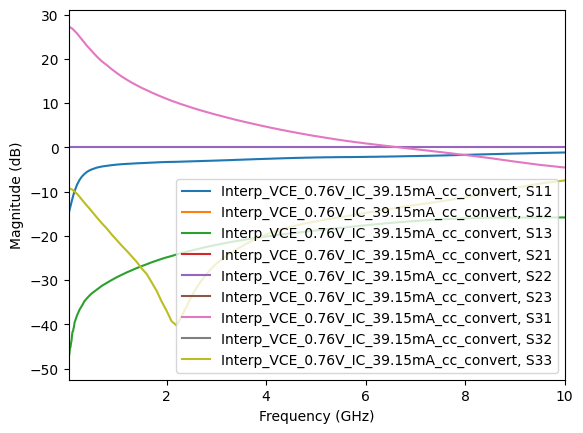

In [8]:
import sys
sys.path.insert(0,'../python_libs')
from rf_simulations import convert_common_emitter_to_common_collector_3port, interpolate_2d_network, convert_to_3port_with_grounded_emitter

### Checking DC Operating point (U6)
DC_VBase_U6 = 2.08			#! SIM VALUE: 2.33 V
DC_VEmitter_U6 = 1.84		#! SIM VALUE: 1.54 V
DC_VCollector_U6 = 2.6		#! SIM VALUE: 1.7 V
DC_IEmitter_U6 = DC_VEmitter_U6 / 47 # Assumption that Ic = Ie
DC_Vce_U6 = DC_VCollector_U6-DC_VEmitter_U6
DC_IEmitter_U6_mA = DC_IEmitter_U6 * 1000
print(f"IEmitter: {DC_IEmitter_U6_mA}")
### U6
filtered_networks_U6 = find_bounding_networks(
	networks,
	vce_target=DC_Vce_U6,
	ic_target=DC_IEmitter_U6_mA)
U6 = interpolate_2d_network(filtered_networks_U6, DC_Vce_U6, DC_IEmitter_U6_mA, interp_kind='linear')
U6_3p_ce = convert_to_3port_with_grounded_emitter(U6)
U6_3p_cb = convert_common_emitter_to_common_collector_3port(U6_3p_ce)
U6_3p_cb.plot_s_db()
print(f"U6_3p.frequency {U6_3p_cb.frequency}")

IEmitter: 11.6
corners: [(2.5, 10.0, 1), (2.5, 12.0, 1), (3.0, 10.0, 1), (3.0, 12.0, 1)]
U8_3p.frequency 0.03-10.0 GHz, 99 pts
[[[ 8.34226974e-01-4.29575878e-02j  0.00000000e+00+0.00000000e+00j
   -2.94200689e-04+1.45846433e-03j]
  [ 0.00000000e+00+0.00000000e+00j -1.00000000e+00+0.00000000e+00j
    0.00000000e+00+0.00000000e+00j]
  [-3.01602147e+01+1.77005168e+00j  0.00000000e+00+0.00000000e+00j
    9.92388292e-01-3.04920703e-02j]]

 [[ 8.34206486e-01-5.84541100e-02j  0.00000000e+00+0.00000000e+00j
    4.61353050e-05+2.25262639e-03j]
  [ 0.00000000e+00+0.00000000e+00j -1.00000000e+00+0.00000000e+00j
    0.00000000e+00+0.00000000e+00j]
  [-3.00951711e+01+2.17889066e+00j  0.00000000e+00+0.00000000e+00j
    9.94587931e-01-4.07814884e-02j]]

 [[ 8.32573337e-01-7.45940185e-02j  0.00000000e+00+0.00000000e+00j
    2.41971413e-04+2.33469774e-03j]
  [ 0.00000000e+00+0.00000000e+00j -1.00000000e+00+0.00000000e+00j
    0.00000000e+00+0.00000000e+00j]
  [-3.03475197e+01+2.50752581e+00j  0.0000000

/home/iwolfs/Work/Projects/rf_lna_project/RF-lna-project/pyenv/lib/python3.12/site-packages/skrf/mathFunctions.py:268: RuntimeWarning: divide by zero encountered in log10
  out = 20 * np.log10(z)


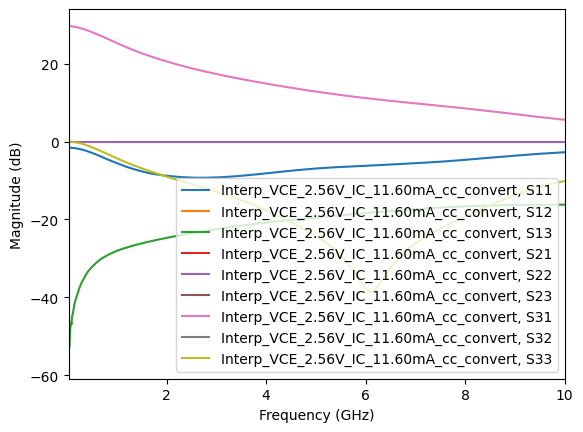

In [11]:
import sys
sys.path.insert(0,'../python_libs')
from rf_simulations import convert_common_emitter_to_common_collector_3port, interpolate_2d_network, convert_to_3port_with_grounded_emitter

### Checking DC Operating point (U8)
DC_VBase_U8 = 2.6			#! SIM VALUE: 3.45 V
DC_VEmitter_U8 = 2.32		#! SIM VALUE: 2.64 V
DC_VCollector_U8 = 4.88		#! SIM VALUE: 5 V
DC_IEmitter_U8 = DC_VEmitter_U8 / 200
DC_Vce_U8 = DC_VCollector_U8-DC_VEmitter_U8
DC_IEmitter_U8_mA = DC_IEmitter_U8 * 1000
print(f"IEmitter: {DC_IEmitter_U8_mA}")


### U8
filtered_networks_U8 = find_bounding_networks(
	networks,
	vce_target=DC_Vce_U8,
	ic_target=DC_IEmitter_U8_mA)
U8 = interpolate_2d_network(filtered_networks_U8, DC_Vce_U8, DC_IEmitter_U8_mA, interp_kind='linear')
U8_3p_ce = convert_to_3port_with_grounded_emitter(U8)
U8_3p_cc = convert_common_emitter_to_common_collector_3port(U8_3p_ce)
U8_3p_cc.plot_s_db()
print(f"U8_3p.frequency {U8_3p_cc.frequency}")
print(U8_3p_cc.s)

### Circuit design

Frequency: 0.9-1.2 GHz, 4 pts, 0.9-1.2 GHz, 4 pts, 0.9-1.2 GHz, 4 pts


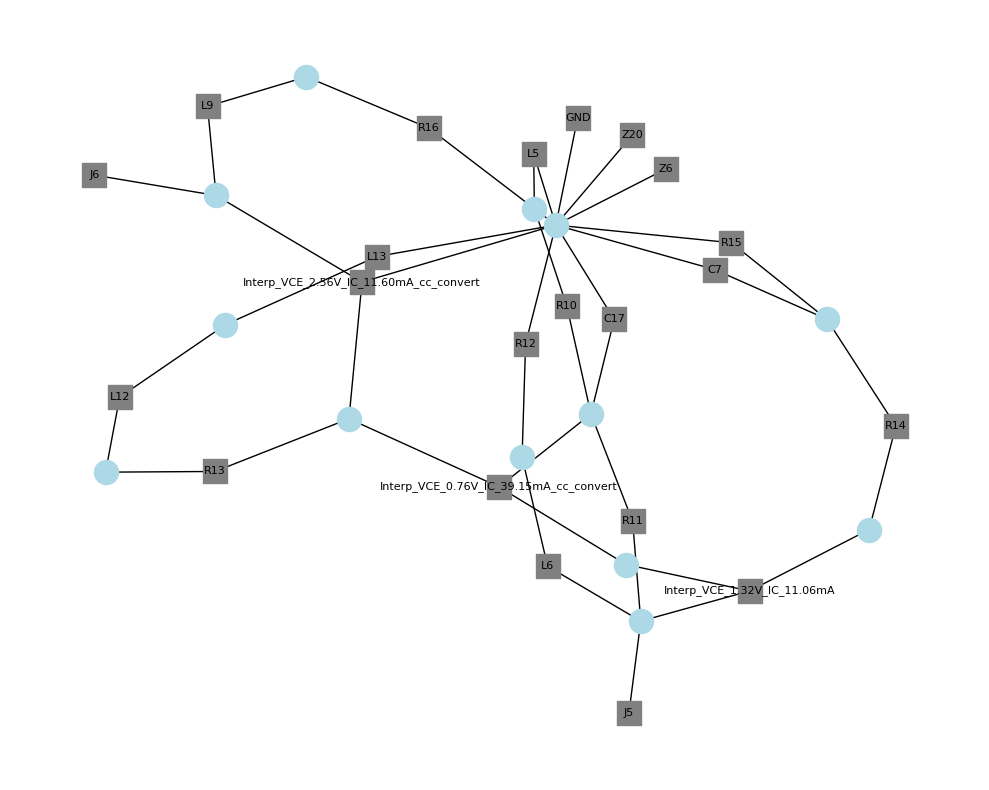

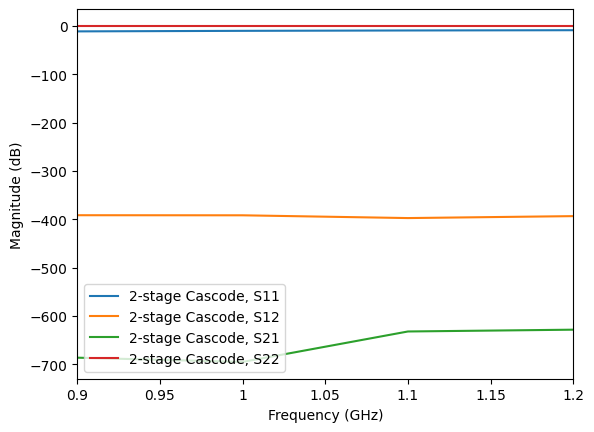

In [7]:
import sys
sys.path.insert(0,'../python_libs')
from rf_simulations import interpolate_2d_network, convert_to_3port_with_grounded_emitter

import skrf as rf
import numpy as np
from skrf.media import MLine, CPW, DefinedGammaZ0
from skrf.circuit import Circuit, Network
import matplotlib.pyplot as plt

Z0 = 50
f_low, f_high = 860e6, 1200e6 #! Matching range
f_low_str, f_high_str = '860MHz', '1200MHz'
# Create passive components
### Transistors
U6_3p = U6_3p_cb[f'{f_low_str}-{f_high_str}'] # Convert to 3-port with grounded emitter (port 2 -> emitter)
U8_3p = U8_3p_cc[f'{f_low_str}-{f_high_str}'] # Convert to 3-port with grounded emitter (port 2 -> emitter)
U7_3p = U7_3p_ce[f'{f_low_str}-{f_high_str}'] # Convert to 3-port with grounded emitter (port 2 -> emitter)

freq = U7_3p.frequency  # scikit-rf Frequency object
print(f"Frequency: {U6_3p.frequency}, {U7_3p.frequency}, {U8_3p.frequency}")
line = DefinedGammaZ0(freq, z0=Z0)


### Inductors
L5 = line.inductor(160e-9, frequency=freq, name='L5')  # 160nH
L6 = line.inductor(160e-9, frequency=freq, name='L6')  # 160nH
L9 = line.inductor(160e-9, frequency=freq, name='L9')   # 160nH
L12 = line.inductor(160e-9, frequency=freq, name='L12')  # 160nH
L13 = line.inductor(160e-9, frequency=freq, name='L13')  # 160nH

### Capacitors
C7 = line.capacitor(100e-12, frequency=freq, name='C7')   # 100pF
C17 = line.capacitor(100e-12, frequency=freq, name='C17')  # 100pF

### Resistors
R10 = line.resistor(2.2e3, frequency=freq, name='R10')  # 2.2kΩ
R11 = line.resistor(1e3, frequency=freq, name='R11')    # 1kΩ
R12 = line.resistor(1e3, frequency=freq, name='R12')    # 1kΩ
R13 = line.resistor(200, frequency=freq, name='R13')    # 200Ω
R14 = line.resistor(0, frequency=freq, name='R14')      # 0Ω
R15 = line.resistor(47, frequency=freq, name='R15')     # 47Ω
R16 = line.resistor(200, frequency=freq, name='R16')    # 200Ω

### Impedances/Transmission lines
Z1 = line.capacitor(3.6e-12, frequency=freq, name='Z1')
Z2 = line.capacitor(1e-12, frequency=freq, name='Z2')
Z4 = line.capacitor(3.6e-12, frequency=freq, name='Z4')
Z5 = line.capacitor(3.6e-12, frequency=freq, name='Z5')
Z6 = line.inductor(15e-9, frequency=freq, name='Z6')               
Z20 = line.inductor(20e-9, frequency=freq, name='Z20')

### PORTS
J5 = rf.Circuit.Port(frequency=freq, name='J5', z0=Z0)  # Input Port
J6 = rf.Circuit.Port(frequency=freq, name='J6', z0=Z0)  # Output Port
GND = rf.Circuit.Ground(frequency=freq, name='GND', z0=Z0)


INPUT_MATCH = False
OUTPUT_MATCH = False

#! CIRCUIT
connections = [
	#! TRANSISTOR CIRCUITS
	### U7
	# Biasing
	[(L6, 1), (R12, 0)],
	# Emitter
	[(R14, 0), (U7_3p, 2)],
	[(R14, 1), (R15, 0), (C7, 0)],

	### U6
	# Emitter
	[(U7_3p, 1), (U6_3p, 0)],
	
	# Base
	[(U6_3p, 2), (C17, 0), (R11, 1), (R10, 0)],
      
	# Biasing
	[(R10, 1), (L5, 0)],
	[(R13, 1), (L12, 0)],
  	[(L12, 1), (L13, 0)],

	# Collector
	[(U6_3p, 1), (R13, 0), (U8_3p, 0)],

	### U8
	# Collector output
	[(L9, 1), (R16, 0)],

	# Ground connections
	[(Z20, 1), (R12, 1), (L5, 1), (L13, 1), (Z6, 1), (R15, 1), (R16, 1), (C7, 1), (U8_3p, 2), (C17, 1), (GND, 0)]
]

if (INPUT_MATCH):
    # INPUT / MATCHING
    connections.append([(J5, 0), (Z2, 0)])
    connections.append([(Z2, 1), (Z4, 0), (Z20, 0)])
    connections.append([(Z4, 1), (R11, 0), (L6, 0), (U7_3p, 0)])
else:
    connections.append([(J5, 0), (R11, 0), (L6, 0), (U7_3p, 0)])

if (OUTPUT_MATCH):
	# OUTPUT / MATCHING
	connections.append([(U8_3p, 1), (J6, 0), (L9, 0)])
	connections.append([(Z6, 0), (Z1, 1), (Z5, 0)])
	connections.append([(Z5, 1), (J6, 0)])
else:
	connections.append([(U8_3p, 1), (J6, 0), (L9, 0)])
    

ckt = rf.Circuit(connections, name='2-stage Cascode', frequency=freq)

ckt.plot_graph(network_labels=True, network_fontsize=8,
               port_labels=True, port_fontsize=8)
plt.show()
ckt.network.plot_s_db()
# plt.show()